In [1]:
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import yaml

from calibration import read_calibration, undistort_image
from color_and_gradient import pipeline

import sys
sys.path.append('../')
from utils.plot_utils import plt_imlist

In [2]:
plt.rcParams["figure.figsize"] = (20,8)
m = read_calibration("intrinsics.yaml")

<Figure size 1440x576 with 0 Axes>

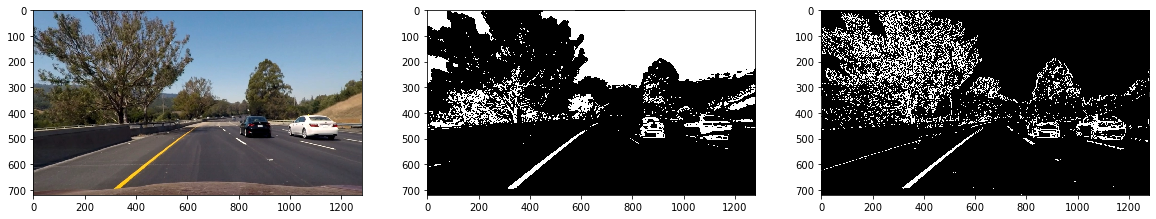

<Figure size 1440x720 with 0 Axes>

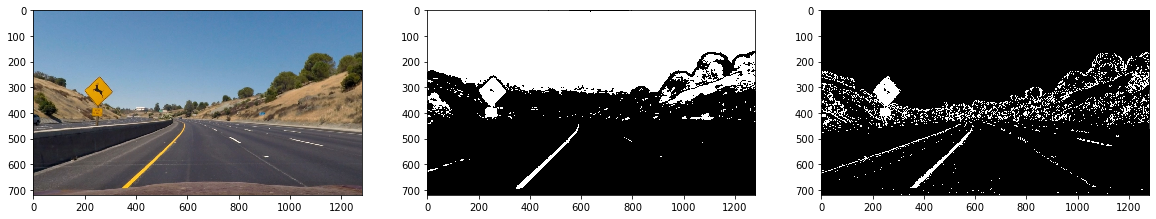

<Figure size 1440x720 with 0 Axes>

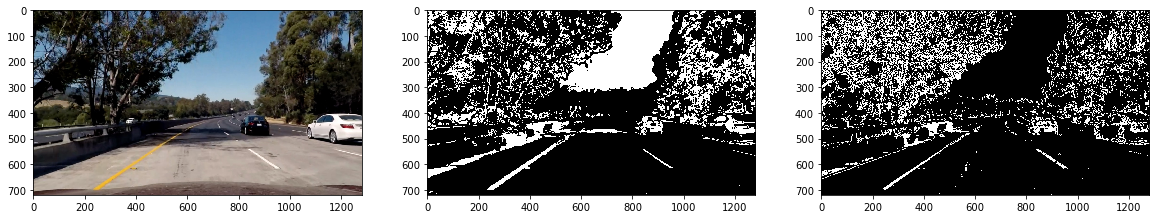

<Figure size 1440x720 with 0 Axes>

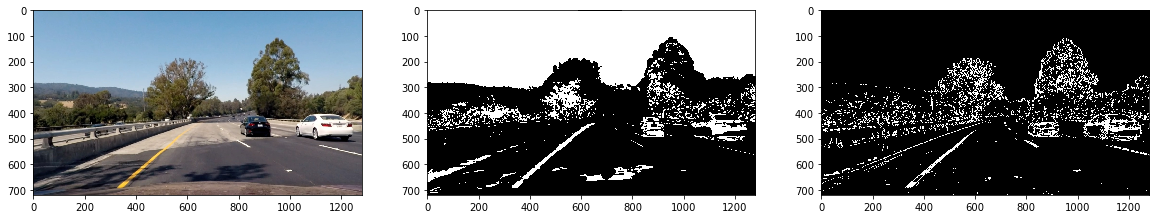

<Figure size 1440x720 with 0 Axes>

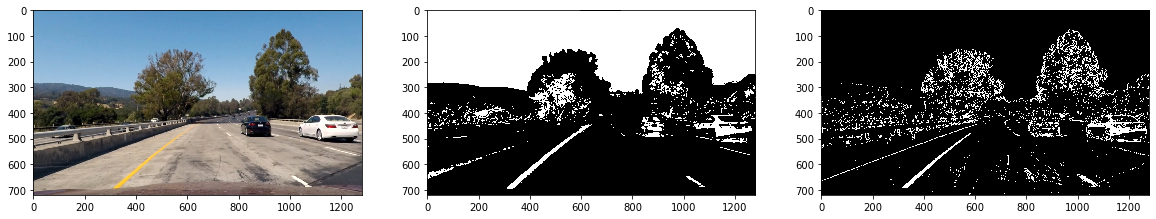

<Figure size 1440x720 with 0 Axes>

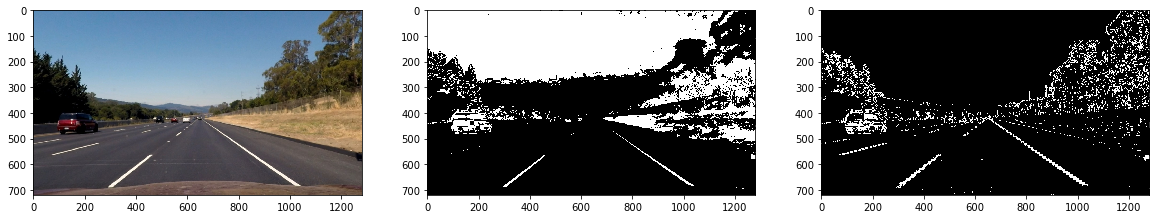

<Figure size 1440x720 with 0 Axes>

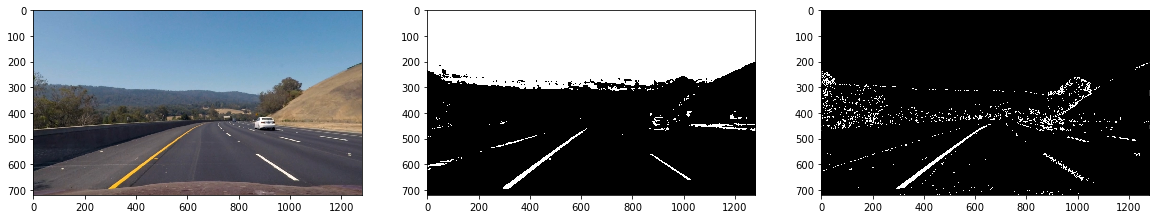

<Figure size 1440x720 with 0 Axes>

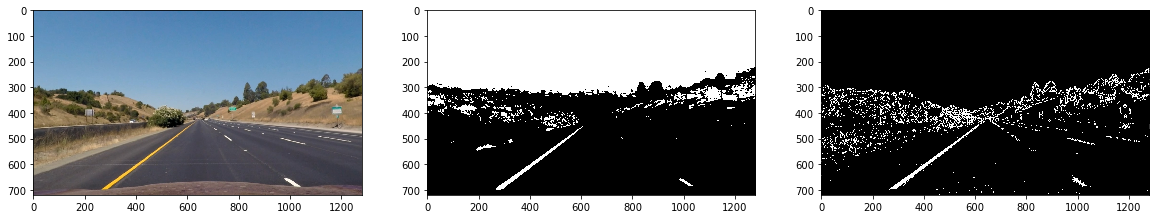

In [3]:
images = glob.glob("test_images/**.jpg")

m = read_calibration("intrinsics.yaml")
for image in images:
    img = mpimg.imread(image)
    img_rect = undistort_image(img, m)
    edge = pipeline(img_rect, s_thresh=(170, 255), sx_thresh=(20, 100))
    plt_imlist([img_rect, edge])
plt.show()